# Age Prediction Using 2D CNN

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses, callbacks
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.io

In [2]:
url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"

dataset = tf.keras.utils.get_file(
    "wiki_crop", url,
    untar=True, cache_dir='',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')

In [3]:
mat = scipy.io.loadmat(os.path.join(dataset_dir, 'wiki.mat'))
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 '__globals__': [],
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 arr

In [4]:
mat['wiki']['dob'][0][0][0]

array([723671, 703186, 711677, ..., 720620, 723893, 713846], dtype=int32)

In [5]:
dob = np.vectorize(lambda x: datetime.datetime.fromordinal(x).year)(mat['wiki']['dob'][0][0][0])
photo_taken = mat["wiki"]["photo_taken"][0][0][0]

age = (photo_taken - dob).astype(np.float32)
age

array([27., 38., 59., ..., 40., 29., 53.], dtype=float32)

In [6]:
file_path = np.vectorize(lambda x: os.path.join(dataset_dir, x[0]))(mat['wiki']['full_path'][0][0][0])
file_path

array(['/tmp/.keras/wiki_crop/17/10000217_1981-05-05_2009.jpg',
       '/tmp/.keras/wiki_crop/48/10000548_1925-04-04_1964.jpg',
       '/tmp/.keras/wiki_crop/12/100012_1948-07-03_2008.jpg', ...,
       '/tmp/.keras/wiki_crop/09/9998109_1972-12-27_2013.jpg',
       '/tmp/.keras/wiki_crop/00/9999400_1981-12-13_2011.jpg',
       '/tmp/.keras/wiki_crop/80/999980_1954-06-11_2008.jpg'],
      dtype='<U59')

In [7]:
file_age_ds = tf.data.Dataset.from_tensor_slices((file_path, age))

In [8]:
def parse_file(filename, label):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.resize(img,[256, 256])
    label = label / 100
    return img, tf.expand_dims(label,0)

In [9]:
image_age_ds = file_age_ds.map(parse_file).shuffle(seed=2, buffer_size=64)
image_age_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [10]:
dataset_size = image_age_ds.cardinality().numpy()
batch_size = 32

AUTOTUNE = tf.data.AUTOTUNE
train_ds = image_age_ds.take(dataset_size*.6).batch(batch_size).prefetch(AUTOTUNE)
val_ds = image_age_ds.skip(dataset_size*.6).take(dataset_size*.2).batch(batch_size).prefetch(AUTOTUNE)
test_ds = image_age_ds.skip(dataset_size*.8).take(dataset_size*.2).batch(batch_size).prefetch(AUTOTUNE)

In [11]:
model = Sequential([
    layers.Input((256, 256,1)),
    layers.Rescaling(1/255),
    layers.Conv2D(32, (7, 7), padding="valid"),
    layers.ReLU(),
    layers.MaxPool2D((4,4), strides=4),

    layers.Conv2D(64,(3,3), padding="valid"),
    layers.ReLU(),
    layers.MaxPool2D((4,4), strides=4),

    layers.Conv2D(128,(3,3), padding="valid"),
    layers.ReLU(),
    layers.MaxPool2D((2,2), strides=2),

    layers.Conv2D(256,(1,1), padding="valid"),
    layers.ReLU(),
    layers.MaxPool2D((2, 2), strides=2),


    layers.Flatten(),
    layers.Dense(64),
    layers.ReLU(),
    layers.Dense(1)

])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      1600      
                                                                 
 re_lu (ReLU)                (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 60, 60, 64)        0         
                                                        

In [13]:
model.compile(
    optimizer="adam",
    loss=losses.MeanSquaredError(),
    metrics=["MAE"]
)

In [14]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        callbacks.TensorBoard(log_dir="logs/ex5")
    ]
)

Epoch 1/10
1169/1169 [==============================] - 100s 81ms/step - loss: 0.0641 - MAE: 0.1459 - val_loss: 0.0414 - val_MAE: 0.1379
Epoch 2/10
1169/1169 [==============================] - 77s 66ms/step - loss: 0.0604 - MAE: 0.1376 - val_loss: 0.0419 - val_MAE: 0.1406
Epoch 3/10
1169/1169 [==============================] - 79s 68ms/step - loss: 0.0589 - MAE: 0.1338 - val_loss: 0.0396 - val_MAE: 0.1285
Epoch 4/10
1169/1169 [==============================] - 76s 65ms/step - loss: 0.0583 - MAE: 0.1321 - val_loss: 0.0399 - val_MAE: 0.1292
Epoch 5/10
1169/1169 [==============================] - 77s 66ms/step - loss: 0.0577 - MAE: 0.1300 - val_loss: 0.0393 - val_MAE: 0.1292
Epoch 6/10
1169/1169 [==============================] - 84s 72ms/step - loss: 0.0572 - MAE: 0.1290 - val_loss: 0.0382 - val_MAE: 0.1247
Epoch 7/10
1169/1169 [==============================] - 86s 73ms/step - loss: 0.0566 - MAE: 0.1270 - val_loss: 0.0388 - val_MAE: 0.1268
Epoch 8/10
1169/1169 [=========================

In [19]:
model.evaluate(test_ds)

390/390 [==============================] - 51s 30ms/step - loss: 0.0316 - MAE: 0.1268


[0.03160707280039787, 0.12677250802516937]

In [26]:
image, label = next(iter(val_ds))
images = image.numpy()[:9]

res = model(image)
res = tf.squeeze(res)
label = tf.squeeze(label)

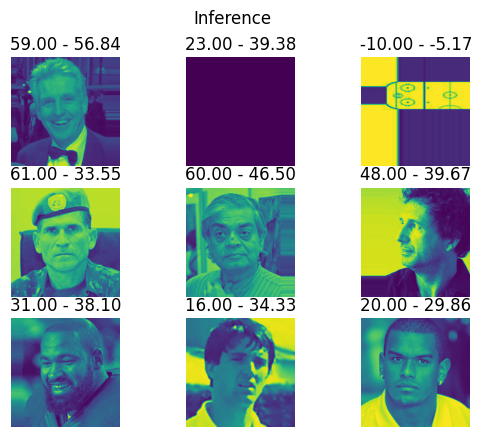

In [28]:
plt.suptitle("Inference")
for i, (img, r) in enumerate(zip(images, res)):
    plt.subplot(331+i)
    plt.title( f"{label[i]*100:.2f} - {res[i]*100:.2f}")
    plt.imshow(img)
    plt.axis("off")
plt.show()
